In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt

import glob

import subprocess
from subprocess import call

import re

import pickle

from gtfparse import read_gtf

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# genes from 2011 paper
genes_42 = 'RASL10B,FGFR1,YPEL2,ENOX2,UFSP1,WDR26,TIAL1,YPEL4,NGF,TRPV6,KCTD11,STARD10,YPEL1,R3HCC1,ZFP62,NHLRC4,EPHX3,C1QL4,TLE3,HDGF,ANKRD42,FAM217B,NFKBID,PTEN,RNF187,METTL23,TMEM8B,VANGL2,FNDC5,C1QL1,CITED1,EIF4G3,HELZ2,CYTH2,NTF3,MFSD4B,C1QL3,KCNN4,IFT46,RASD2,CITED2,C1QL2'.split(',')
genes_17 = 'GTF3A, EIF4G2, SP3, PRPS1L1, TEAD4, TEAD3, CACNG8, OAZ3, TEAD1, DDX17, VEGFA, NR1I2, HCK, WT1, BAG1, NPW, MYC'.split(', ')

In [3]:
# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/local_and_global_df_g25ovlp_g35ovlp_g38ovlp_refseqovlp_strand_FRAMES_PhyloCSF.txt', sep='\t')

metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')
print (metadata_pc_g25.shape)

metadata_pc_g35 = pd.read_csv('tmp_res/metadata_pc_g35.txt', sep='\t')
print (metadata_pc_g35.shape)


# open SET1 (PhyloSET) and SET2 (RiboSET)
SET1 = pd.read_csv('tmp_res/SET1.txt', sep='\t')
SET2 = pd.read_csv('tmp_res/SET2.txt', sep='\t')

(94359, 14)
(101486, 14)


In [4]:
SET2.columns

Index(['tr_id', 'gene', 'N_term_start1', 'N_term_end1', 'len_codons',
       'global_coo_50_and_less', 'strand', 'global_coo_primary',
       'PhyloCSF120score', 'number_of_records', 'ovlp', 'Riboseq_Summary',
       'Coverage_value_ext', 'Proteomics_count_ext', 'tag', 'transcript_type',
       'CDS_ratio'],
      dtype='object')

In [5]:
SET2[SET2['Riboseq_Summary'].str.contains('ATG')]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio
95,ENST00000467087.5,STIM2,258,528,90.0,chr4:26861069-26861218,+,chr4:26860949-26861218,-953.1598,64,0;0;0,ATG; 268-529; Rank: 462; cov: 73.17,73.170732,0.0,"non_ATG_start,basic,appris_principal_3,CCDS",protein_coding,0.139053
119,ENST00000316788.11,AP3S1,251,557,102.0,chr5:115841888-115842037,+,chr5:115841732-115842037,-1017.9102,94,0;0;0,ATG; 258-558; Rank: 121; cov: 68.42,68.421053,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.325754
218,ENST00000418331.6,PTPRJ,1,352,117.0,chr11:47980763-47980912,+,chr11:47980562-47980912,-342.5714,48,0;0;0,ATG; 11-353; Rank: 369; cov: 60.55,60.550459,2.0,"basic,appris_principal_2,CCDS",protein_coding,0.407875


In [6]:
# open file with extension sequences from 2011 paper 
# there is .pdf file in supplementary data -> I took sequences manually from them 
EXT_SEQ_DF = pd.read_csv('data/extensions_from_2011.txt', sep='\t')

# Open files associated with supplements of 2011 paper

* comparison_of_paper_trs_with_newer_refseq_release.txt = compares sequences and ids between old refseq release (33) and new one
* refseq_paper_ids.txt = list of refseq ids from paper

In [7]:
ids = pd.read_csv('data/refseq_paper_ids.txt', sep='\t')#[['RefSeq ID', 'Gene Name', 'Start', 'Extension length, codons', 'Unnamed: 5']]

ids.columns = ['refseq_ID', 'Gene_name_refseq', 'Start_codon', 'Ext_length', '42_or_17']

ids['refseq_ID1'] = ['NM_001042589','NM_001037335', 'NM_001010858', 'NM_001136108', 'NM_003760',
 'NM_006375', 'NM_176677', 'NM_153756', 'NM_006688', 'NM_145008', 'NM_182528',
 'NM_000314', 'NM_139239', 'NM_001015072', 'NM_020153', 'NM_001005404', 'NM_020335',
 'NM_017457', 'NM_001010908', 'NM_001008223', 'NM_001002914', 'NM_025160', 'NM_005078', 'NM_002250',
 'NM_004494', 'NM_013313', 'NM_022106', 'NM_006079', 'NM_182603', 'NM_014310', 'NM_002506', 'NM_152283',
 'NM_001102654', 'NM_003252', 'NM_024794', 'NM_018646', 'NM_033315',
 'NM_001080510', 'NM_023110', 'NM_153369', 'NM_001144886', 'NM_006645', 'NM_002097', 'NM_001418','NM_001017371','NM_175886',
 'NM_003213', 'NM_003214', 'NM_031895', 'NM_016178', 'NM_021961', 'NM_001098504', 'NM_001025366', 'NM_022002',
 'NM_001172131', 'NM_000378', 'NM_001172415', 'NM_001099456','NM_002467']

ids['gene'] = ['TMEM8B', 'HELZ2', 'RNF187', 'R3HCC1', 'EIF4G3', 'ENOX2', 'NHLRC4', 'FNDC5', 'ANKRD42',
 'YPEL4', 'C1QL2', 'PTEN', 'NFKBID', 'UFSP1', 'IFT46', 'YPEL2', 'VANGL2', 'CYTH2', 'C1QL3',
 'C1QL4', 'KCTD11', 'WDR26', 'TLE3', 'KCNN4', 'HDGF', 'YPEL1', 'FAM217B', 'CITED2',
 'C1QL1', 'RASD2', 'NGF', 'ZFP62', 'NTF3', 'TIAL1', 'EPHX3', 'TRPV6', 'RASL10B',
 'METTL23', 'FGFR1', 'MFSD4B', 'CITED1', 'STARD10', 'GTF3A', 'EIF4G2', 'SP3', 'PRPS1L1',
 'TEAD4', 'TEAD3', 'CACNG8', 'OAZ3', 'TEAD1', 'DDX17', 'VEGFA', 'NR1I2',
 'HCK', 'WT1', 'BAG1', 'NPW', 'MYC']

cases = pd.read_csv('data/comparison_of_paper_trs_with_newer_refseq_release.txt', sep='\t')[['refseq_id', 'annotater_OR_not_n_new_release', 'extension_exist_in_new_release', 'length']]

cases['refseq_ID'] = [x.split('.')[0] for x in cases['refseq_id'].tolist()]

cases = cases.merge(ids, on='refseq_ID', how='inner')

print (cases.shape)


cases[0:2]

(59, 11)


,refseq_id,annotater_OR_not_n_new_release,extension_exist_in_new_release,length,refseq_ID,Gene_name_refseq,Start_codon,Ext_length,42_or_17,refseq_ID1,gene
0,NM_001172415.2,primary_longer_3end_cdsATG_downstream,not_ok,NaN,NM_001172415,BAG1,CUG,71,17,NM_001172415,BAG1
1,NM_022002.2,diff_primary,not_ok,NaN,NM_022002,NR1I2,CUG,55,17,NM_022002,NR1I2


# We are going to search extension sequences among only PROTEIN_CODING transcripts with COMPLETE CDS

In [8]:
# returns GTF with essential columns such as "feature", "seqname", "start", "end"
# alongside the names of any optional keys which appeared in the attribute column
df_g25 = read_gtf("data/gencode.v25.annotation.gtf")

df_CDS_g25 = df_g25[df_g25["feature"] == "CDS"]
annotation_CDS_g25 = df_CDS_g25[['transcript_id', 'transcript_type', 'gene_name', 'tag']]
annotation_CDS_g25.columns = ['tr_id', 'transcript_type', 'gene', 'tag']

df_g35 = read_gtf("data/gencode.v35.annotation.gtf")

df_CDS_g35 = df_g35[df_g35["feature"] == "CDS"]
annotation_CDS_g35 = df_CDS_g35[['transcript_id', 'transcript_type', 'gene_name', 'tag']]
annotation_CDS_g35.columns = ['tr_id', 'transcript_type', 'gene', 'tag']

metadata_pc_g25 = metadata_pc_g25.merge(annotation_CDS_g25, on=['tr_id', 'gene'], how='inner').drop_duplicates()
metadata_pc_g35 = metadata_pc_g35.merge(annotation_CDS_g35, on=['tr_id', 'gene'], how='inner').drop_duplicates()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_status', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_status', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


# Cases annotated in g35: they are in CDS from 1st position 

In [9]:
li = []

for el in metadata_pc_g35[['tr_id', 'gene', 'utr5_start', 'utr5_end', 'transcript_seq', 'transcript_type', 'tag']].to_numpy():
    nte_start = el[2]
    nte_end_plus_cds_start = el[3]+3
    cds_start = el[3]
    cds_seq = el[-3][cds_start:]
    nte_seq = el[-3][nte_start:nte_end_plus_cds_start]
    
    biotype = el[-2]
    tag = el[-1]
    
    li.append([el[0], el[1], cds_seq, nte_seq, biotype, tag])
    
seq_df_g35 = pd.DataFrame(li, columns = ['tr_id', 'gene', 'cds', 'nte', 'biotype', 'tag']).merge(cases[['refseq_id', 'gene']], on='gene', how='inner')

print (seq_df_g35.gene.nunique())

seq_df_g35_ext = seq_df_g35.merge(EXT_SEQ_DF[['ext_seq', 'gene']], on='gene', how='inner')

print (seq_df_g35_ext.gene.nunique())

seq_df_g35_ext[0:2]

59
59


,tr_id,gene,cds,nte,biotype,tag,refseq_id,ext_seq
0,ENST00000374935.7,EIF4G3,ATGAATTCACAACCTCAAACCCGTTCTCCGTTTTTCCAGAGGCCTC...,GCCGGACTGCTGGAGGCGGCCACAGCGCCATGTTGGATGCTCTGCT...,protein_coding,"basic,appris_alternative_2",NM_003760.4,ATCCACCGGCATCGCCTGAGCCCCGCTACCGAGAAGGGCGCCGCTT...
1,ENST00000264211.12,EIF4G3,ATGAATTCACAACCTCAAACCCGTTCTCCGTTTTTCCAGAGGCCTC...,GTAACACAAGTGGCAAGACAGCCGGGAACCCCTACCCCATCCCCTT...,protein_coding,"basic,appris_principal_3,CCDS",NM_003760.4,ATCCACCGGCATCGCCTGAGCCCCGCTACCGAGAAGGGCGCCGCTT...


In [10]:
NM_020153_seq = 'ATAGAGGAGACGGATTCAGAAGGGCTACAGACCAAGGTTGTTGAAAACCAAACATATGATGAGCGTCTAGAGATTAACGACTCCGAAGAGGTTGCAAGTATTTATACTCCAACCCCAAGACACCAAGGACTTCCTCGTTCTGCCCATCTTCCTAACAAGGCTATG'
NM_001080510_seq = 'CTGGCAGCCCGGAGCCTTCCGCGGTCCCCCACCCGCCCGGGGCCCAACGACGCCCTACTGGGCGAGCACGATTTCCGAGGACAGGGGGTCCGGGCCCAGCGCTTTCGATTCTCGGAGGAGCCGGGTCCGGGGGCCGACGGGGCTGTCCTGGAGGTCCACGTCCCGCAGGTCCTGCATCTCCAGTATGGAATG'

In [11]:
METTL23_ext_seq = NM_001080510_seq
METTL23_ext_seq_AG = 'CTGGCAGCCCGGAGCCTTCCGCGGTCCCCCGCCCGCCCGGGGCCCAACGACGCCCTACTGGGCGAGCACGATTTCCGAGGACAGGGGGTCCGGGCCCAGCGCTTTCGATTCTCGGAGGAGCCGGGTCCGGGGGCCGACGGGGCTGTCCTGGAGGTCCACGTCCCGCAGGTCCTGCATCTCCAGTATGGAATG'
for i, x in enumerate(zip(METTL23_ext_seq, METTL23_ext_seq_AG)):
    if x[0] != x[1]:
        print (i, x[0], x[1])

30 A G


In [12]:
IFT46_ext_seq = NM_020153_seq
IFT46_ext_seq_ch = 'ATAGAGGAGACGGATTCAGAAGGGCTACAGACCAAGGTTGTTGAAAACCAGACATATGATGAGCGTCTAGAGATTAACGACTCCGAAGAGGTTGCAAGTATTTATACTCCAACCCCAAGACACCAAGGACTTCCTCGTTCTGCCCATCTTCCTAACAAGGCTATG'
for i, x in enumerate(zip(IFT46_ext_seq, IFT46_ext_seq_ch)):
    if x[0] != x[1]:
        print (i, x[0], x[1])

50 A G


In [13]:
li = []

for i in range(seq_df_g35_ext.shape[0]):
    trid = seq_df_g35_ext.iloc[i].tr_id
    gene = seq_df_g35_ext.iloc[i].gene
    refseq_id = seq_df_g35_ext.iloc[i].refseq_id
    
    nte_seq = seq_df_g35_ext.iloc[i].nte
    cds_seq = seq_df_g35_ext.iloc[i].cds
    ext = seq_df_g35_ext.iloc[i].ext_seq
    
    biotype = seq_df_g35_ext.iloc[i].biotype
    tag = seq_df_g35_ext.iloc[i].tag
    
    if gene == 'IFT46':
        ext = IFT46_ext_seq_ch
    if gene == 'METTL23':
        ext = METTL23_ext_seq_AG
    
    li.append([trid, gene, refseq_id, cds_seq.find(ext), nte_seq.find(ext), biotype, tag])
    
EXT_FOUND_g35 = pd.DataFrame(li, columns = ['tr_id', 'gene', 'refseq_id', 'cds_find', 'nte_find', 'biotype', 'tag'])
EXT_FOUND_g35[0:5]

,tr_id,gene,refseq_id,cds_find,nte_find,biotype,tag
0,ENST00000374935.7,EIF4G3,NM_003760.4,-1,61,protein_coding,"basic,appris_alternative_2"
1,ENST00000264211.12,EIF4G3,NM_003760.4,-1,-1,protein_coding,"basic,appris_principal_3,CCDS"
2,ENST00000602326.5,EIF4G3,NM_003760.4,-1,23,protein_coding,"basic,appris_alternative_2,CCDS"
3,ENST00000400422.6,EIF4G3,NM_003760.4,-1,20,protein_coding,"basic,appris_alternative_2,CCDS"
4,ENST00000634879.1,EIF4G3,NM_003760.4,9,-1,protein_coding,"non_ATG_start,non_submitted_evidence,basic"


In [14]:
ANNOTATED_EXT_FOUND_df_g35 = EXT_FOUND_g35[EXT_FOUND_g35['cds_find'] == 0]

ANNOTATED_EXT_FOUND_df_g35_2 = ANNOTATED_EXT_FOUND_df_g35.merge(seq_df_g35_ext[['tr_id', 'gene', 'refseq_id']], on=['tr_id', 'gene', 'refseq_id'], how='inner')

print ('%s/59 are annotated in g35 regardless of biotype and tags' % (ANNOTATED_EXT_FOUND_df_g35_2.gene.nunique()))
print (', '.join(ANNOTATED_EXT_FOUND_df_g35_2.gene.unique()))
print ()


# remove CDS-incomplete and non-protein-coding 
ANNOTATED_EXT_FOUND_df_g35_3 = ANNOTATED_EXT_FOUND_df_g35_2[(ANNOTATED_EXT_FOUND_df_g35_2['biotype'] == 'protein_coding') &
                                                           (~ANNOTATED_EXT_FOUND_df_g35_2['tag'].str.contains('cds_start_NF')) &
                                                           (~ANNOTATED_EXT_FOUND_df_g35_2['tag'].str.contains('cds_end_NF'))]

print ('%s/59 are annotated in g35: only protein-coding transcripts with complete CDS' % (ANNOTATED_EXT_FOUND_df_g35_3.gene.nunique()))
print (', '.join(ANNOTATED_EXT_FOUND_df_g35_3.gene.unique()))
print ()

ANNOTATED_EXT_FOUND_df_g35_li = list(ANNOTATED_EXT_FOUND_df_g35_3.gene.unique())

print (ANNOTATED_EXT_FOUND_df_g35_3.shape[0], ANNOTATED_EXT_FOUND_df_g35_2.shape[0], len(ANNOTATED_EXT_FOUND_df_g35_li))

ANNOTATED_EXT_FOUND_df_g35_3.to_csv('tmp_res/ANNOTATED_EXT_FOUND_df_g35_pc_complete_CDS.txt', sep='\t', index=False)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


24/59 are annotated in g35 regardless of biotype and tags
FNDC5, OAZ3, RNF187, SP3, NR1I2, TEAD3, VEGFA, PRPS1L1, TRPV6, R3HCC1, MYC, BAG1, EIF4G2, WT1, TEAD4, GTF3A, NPW, KCTD11, YPEL2, NFKBID, CACNG8, HCK, YPEL1, DDX17

24/59 are annotated in g35: only protein-coding transcripts with complete CDS
FNDC5, OAZ3, RNF187, SP3, NR1I2, TEAD3, VEGFA, PRPS1L1, TRPV6, R3HCC1, MYC, BAG1, EIF4G2, WT1, TEAD4, GTF3A, NPW, KCTD11, YPEL2, NFKBID, CACNG8, HCK, YPEL1, DDX17

45 56 24


In [2]:
s = 'FNDC5, OAZ3, RNF187, SP3, NR1I2, TEAD3, VEGFA, PRPS1L1, TRPV6, R3HCC1, MYC, BAG1, EIF4G2, WT1, TEAD4, GTF3A, NPW, KCTD11, YPEL2, NFKBID, CACNG8, HCK, YPEL1, DDX17'

s.split(', ')

['FNDC5',
 'OAZ3',
 'RNF187',
 'SP3',
 'NR1I2',
 'TEAD3',
 'VEGFA',
 'PRPS1L1',
 'TRPV6',
 'R3HCC1',
 'MYC',
 'BAG1',
 'EIF4G2',
 'WT1',
 'TEAD4',
 'GTF3A',
 'NPW',
 'KCTD11',
 'YPEL2',
 'NFKBID',
 'CACNG8',
 'HCK',
 'YPEL1',
 'DDX17']

# Cases with intact extensions  in  5'UTRs of g35

In [15]:
INTACT_EXT_FOUND_df_g35 = EXT_FOUND_g35[(EXT_FOUND_g35['nte_find'] > 0) & (~EXT_FOUND_g35['gene'].isin(ANNOTATED_EXT_FOUND_df_g35_li))]

INTACT_EXT_FOUND_df_g35_2 = INTACT_EXT_FOUND_df_g35.merge(seq_df_g35_ext[['tr_id', 'gene', 'refseq_id']], on=['tr_id', 'gene', 'refseq_id'], how='inner')


print ('%s/59 have intact extensions in 5UTR regardless of biotype and tags' % INTACT_EXT_FOUND_df_g35_2.gene.nunique())

# remove CDS-incomplete and non-protein-coding 
INTACT_EXT_FOUND_df_g35_3 = INTACT_EXT_FOUND_df_g35_2[(INTACT_EXT_FOUND_df_g35_2['biotype'] == 'protein_coding') &
                                                           (~INTACT_EXT_FOUND_df_g35_2['tag'].str.contains('cds_start_NF')) &
                                                           (~INTACT_EXT_FOUND_df_g35_2['tag'].str.contains('cds_end_NF'))]

INTACT_EXT_FOUND_li_g35 = list(INTACT_EXT_FOUND_df_g35_3.gene.unique())

#print (INTACT_EXT_FOUND_df_g35_3.shape, INTACT_EXT_FOUND_df_g35_2.shape, len(INTACT_EXT_FOUND_li_g35))

print ('%s/59 have intact extensions in 5UTR of protein coding trs with complete CDS' % INTACT_EXT_FOUND_df_g35_3.gene.nunique())

29/59 have intact extensions in 5UTR regardless of biotype and tags
28/59 have intact extensions in 5UTR of protein coding trs with complete CDS


In [16]:
set(INTACT_EXT_FOUND_df_g35_2.gene.unique()) -  set(INTACT_EXT_FOUND_df_g35_3.gene.unique())

{'TIAL1'}

In [17]:
INTACT_EXT_FOUND_df_g35_2[INTACT_EXT_FOUND_df_g35_2['gene'] == 'TIAL1']

,tr_id,gene,refseq_id,cds_find,nte_find,biotype,tag
33,ENST00000497671.5,TIAL1,NM_003252.3,-1,294,nonsense_mediated_decay,


# remaining genes in g35

In [18]:
REMAINING_GENES_li_g35 = set(genes_17+genes_42) - set(INTACT_EXT_FOUND_li_g35+ANNOTATED_EXT_FOUND_df_g35_li)

REMAINING_GENES_df_g35 = seq_df_g35_ext[seq_df_g35_ext['gene'].isin(REMAINING_GENES_li_g35)]

', '.join(REMAINING_GENES_df_g35.gene.unique())

'WDR26, ZFP62, PTEN, TIAL1, ANKRD42, C1QL1, HELZ2'

In [20]:
REMAINING_GENES_li_g35

{'ANKRD42', 'C1QL1', 'HELZ2', 'PTEN', 'TIAL1', 'WDR26', 'ZFP62'}

In [23]:
seq_df_g35_ext[seq_df_g35_ext['gene'].isin(REMAINING_GENES_li_g35)][['refseq_id', 'gene']].drop_duplicates()

,refseq_id,gene
27,NM_025160.6,WDR26
43,NM_152283.4,ZFP62
149,NM_000314.8,PTEN
151,NM_003252.3,TIAL1
210,NM_006688.5,ANKRD42
268,NM_182603.4,C1QL1
320,NM_001037335.2,HELZ2


# save

In [19]:
ANNOTATED_EXT_FOUND_df_g35_3.to_csv('tmp_res/ANNOTATED_EXT_FOUND_df_g35_PC_COMPLETE_CDS.txt', sep='\t', index=False)
INTACT_EXT_FOUND_df_g35_3.to_csv('tmp_res/INTACT_EXT_FOUND_df_g35_PC_COMPLETE_CDS.txt', sep='\t', index=False)

In [18]:
REMAINING_GENES_df_g35[['refseq_id', 'gene']].drop_duplicates()

,refseq_id,gene
27,NM_025160.6,WDR26
43,NM_152283.4,ZFP62
149,NM_000314.8,PTEN
151,NM_003252.3,TIAL1
210,NM_006688.5,ANKRD42
268,NM_182603.4,C1QL1
320,NM_001037335.2,HELZ2


# Check whether genes with intact extensions from gencode 35 (24) are supported by SET1 (PhyloSET)

In [19]:
ANNOTATED_EXT_FOUND_df_g35_3.gene.nunique(), INTACT_EXT_FOUND_df_g35_3.gene.nunique(), REMAINING_GENES_df_g35.gene.nunique()

(24, 28, 7)

In [20]:
print ('genes with remaining ext in g 35 supported by SET1 / 24')
set(SET1.gene.unique()).intersection(INTACT_EXT_FOUND_df_g35_3[INTACT_EXT_FOUND_df_g35_3['gene'].isin(genes_42+genes_17)].gene.unique())

genes with remaining ext in g 35 supported by SET1 / 24


{'C1QL2', 'C1QL3', 'CYTH2', 'VANGL2'}

In [21]:
print ('genes with remaining ext in g 35 supported by SET1 / 7')
print (list(REMAINING_GENES_df_g35.merge(SET1, on=['tr_id', 'gene'], how='inner').gene.unique()))

genes with remaining ext in g 35 supported by SET1 / 7
['HELZ2']


In [22]:
REMAINING_GENES_df_g35[REMAINING_GENES_df_g35['gene'] == 'HELZ2'].iloc[0].ext_seq

'GTGGCGCCTCCAGGGTCCACCCTGCTGCCCAACAGCCCCGCGGCCACCAGAGGGCCGTCCCTGGCCCGGCTGTGTGCCCTGGTGGACCTGTGTCTGGGCTGCTCCCGCTGCACCCAGCGGCTCAATGAAAGCACCTACGTCCTCCGTAGGGTGGAGCATGACTGCTCCCGCGAGATCCTGCTGGCCCGCTTTAAGCAGGCCACCAAGAGCAAGGTCTGGCGCGTGGTGGGCTGCCGGCCCACCTTCCCAAGGCCCCTGTGCTACCAAGTCTGCCACTACTACAGCCCTGGGCTCGGCTGCCGGCGCCACCGAAACCGGTGCACCTTTGCCCGCAGTCGCGAGGAGGCCCTGGTCTGGACCTTCGAGCGTCAGCACAACCTCCAGCGCCTATGGCTGAAGGCGGAGGTGCAGGGCAGCGGGGCCCAGGGAGGGGCAGGCCGGGCGGCCGACGCCATCCTTACGGAGTTTGGCGGCCGCTTCGAGCTGCTTTGCTCCCTCTGCTTCAGGCGCTGTCCCCCATGCATCTGTCGCGTGGACCCCCAGGGGCAGTGCCCTGAGCACGGAGCCTGCCCCTCCCTCCTGGCCCACGTGAGCGCCGAGGGCCGCCGCAAGCAACAGTTTGTGGTGGTGAGGCCGCGGCCCCGGGCCGGCCAGCCTCCTGCCTACTGCAGGTTTGTGGGGCGTGGGCAGCCGTGCTGGCGTGGGGAGTCCCGCTGCCAGTTTGCACACAGCGCCGTGGAGATG'

In [23]:
metadata_pc_g35[metadata_pc_g35['gene'] == 'HELZ2'].iloc[1].transcript_seq

# ENST00000427522.6, ENST00000467148.1

'GTTTGTGGGGCGTGGGCAGCCGTGCTGGCGTGGGGAGTCCCGCTGCCAGTTTGCACACAGCGCCGTGGAGATGGCTGTGTGGGAGGCCGAGCAGCTGGGTGGCCTCCAGCGGGGGGACCTGCTCACACCCCCTGCCCCTGATGGCGACGGGCGCACGGCCCCCCTTGGCCAGCCCCCTGGGGCCCAGCTGTACTGCCCGGCCTGCTTGGTCACCTGCCACTCTCAGGAGGCCTTCGAGAACCACTGCGCATCCTCGGAGCACGCACAGATGGTGGCCTTCGACCAGGCCCTGCCCTGGGAGCACCGTTCCCCACCCCCGGGACTCTCCAAGTTCGAGCTCTGCCCAAAGCCTGACCTCTGTGAGTATGGGGACGCCTGCACCAAGGCACACTCAGCACAGGAGCTGCAGGAGTGGGTCCGGCGCACGCAGGCTGTGGAGCTGCGGGGGCAGGCGGCCTGGCAGGACGGGCTGGTGCCCTACCAGGAGCGGCTGCTGGCCGAGTACCAGCGCAGCAGCAGTGAGGTCCTTGTGCTGGCAGAGACCCTTGATGGAGTGCGTGTCACCTGCAACCAGCCCCTGATGTACCAGGCCCAGGAGAGGAAGACCCAGTACAGCTGGACGTTTGCCGTCCACTCTGAGGAGCCCCTGCTACACGTGGCCCTGCTGAAGCAGGAGCCAGGAGCCGACTTCTCTCTGGTGGCTCCCGGCCTCCCGCCAGGCCGGCTCTACGCACGGGGTGAGCGCTTCCGTGTGCCCAGCTCCACTGCCGACTTCCAGGTGGGAGTGCGTGTGCAGGCTGCCTCGTTCGGCACCTTTGAGCAATGGGTGGTCTTCGACTTTGGCCGCCGGCCGGTGCTGCTACAAAAGCTGGGGCTGCAGCTGGGCCAGGGGCGTCGCCCAGGACCCTGCAGGAATCTGGCGCTCGGCCACCCTGAGGAGATGGAGCGCTGGCACACTGGCAACCGCCACGTGGTGCCTGGCGTGGAGCGGACGGCCGA

# Check whether genes with intact extensions from gencode 35 (24) are supported by SET2 (RiboSET)

In [24]:
print ('genes with remaining ext in g 35 supported by SET2 / 24')
set(SET2.gene.unique()).intersection(INTACT_EXT_FOUND_df_g35_3[INTACT_EXT_FOUND_df_g35_3['gene'].isin(genes_42+genes_17)].gene.unique())

genes with remaining ext in g 35 supported by SET2 / 24


{'CYTH2', 'HDGF'}

In [25]:
print ('genes with remaining ext in g 35 supported by SET2 / 7')
print (list(REMAINING_GENES_df_g35.merge(SET2, on=['tr_id', 'gene'], how='inner').gene.unique()))

genes with remaining ext in g 35 supported by SET2 / 7
[]


# PTEN

In [26]:
EXT_SEQ_DF[EXT_SEQ_DF['gene'] == 'PTEN'].iloc[0].ext_seq

'CTGGAGCGGGGGGGAGAAGCGGCGGCGGCGGCGGCCGCGGCGGCTGCAGCTCCAGGGAGGGGGTCTGAGTCGCCTGTCACCATTTCCAGGGCTGGGAACGCCGGAGAGTTGGTCTCTCCCCTTCTACTGCCTCCAACACGGCGGCGGCGGCGGCGGCACATCCAGGGACCCGGGCCGGTTTTAAACCTCCCGTCCGCCGCCGCCGCACCCCCCGTGGCCCGGGCTCCGGAGGCCGCCGGCGGAGGCAGCCGTTCGGAGGATTATTCGTCTTCTCCCCATTCCGCTGCCGCCGCTGCCAGGCCTCTGGCTGCTGAGGAGAAGCAGGCCCAGTCGCTGCAACCATCCAGCAGCCGCCGCAGCAGCCATTACCCGGCTGCGGTCCAGAGCCAAGCGGCGGCAGAGCGAGGGGCATCAGCTACCGCCAAGTCCAGAGCCATTTCCATCCTGCAGAAGAAGCCCCGCCACCAGCAGCTTCTGCCATCTCTCTCCTCCTTTTTCTTCAGCCACAGGCTCCCAGACATG'

In [27]:
EXT_SEQ_DF[EXT_SEQ_DF['gene'] == 'PTEN'].iloc[0].ext_seq

'CTGGAGCGGGGGGGAGAAGCGGCGGCGGCGGCGGCCGCGGCGGCTGCAGCTCCAGGGAGGGGGTCTGAGTCGCCTGTCACCATTTCCAGGGCTGGGAACGCCGGAGAGTTGGTCTCTCCCCTTCTACTGCCTCCAACACGGCGGCGGCGGCGGCGGCACATCCAGGGACCCGGGCCGGTTTTAAACCTCCCGTCCGCCGCCGCCGCACCCCCCGTGGCCCGGGCTCCGGAGGCCGCCGGCGGAGGCAGCCGTTCGGAGGATTATTCGTCTTCTCCCCATTCCGCTGCCGCCGCTGCCAGGCCTCTGGCTGCTGAGGAGAAGCAGGCCCAGTCGCTGCAACCATCCAGCAGCCGCCGCAGCAGCCATTACCCGGCTGCGGTCCAGAGCCAAGCGGCGGCAGAGCGAGGGGCATCAGCTACCGCCAAGTCCAGAGCCATTTCCATCCTGCAGAAGAAGCCCCGCCACCAGCAGCTTCTGCCATCTCTCTCCTCCTTTTTCTTCAGCCACAGGCTCCCAGACATG'

In [28]:
metadata_pc_g35[metadata_pc_g35['gene'] == 'PTEN'].iloc[0]['5UTR_start_seq']

'GTTCTCTCCTCTCGGAAGCTGCAGCCATGATGGAAGTTTGAGAGTTGAGCCGCTGTGAGGCGAGGCCGGGCTCAGGCGAGGGAGATGAGAGACGGCGGCGGCCGCGGCCCGGAGCCCCTCTCAGCGCCTGTGAGCAGCCGCGGGGGCAGCGCCCTCGGGGAGCCGGCCGGCCTGCGGCGGCGGCAGCGGCGGCGTTTCTCGCCTCCTCTTCGTCTTTTCTAACCGTGCAGCCTCTTCCTCGGCTTCTCCTGAAAGGGAAGGTGGAAGCCGTGGGCTCGGGCGGGAGCCGGCTGAGGCGCGGCGGCGGCGGCGGCACCTCCCGCTCCTGGAGCGGGGGGGAGAAGCGGCGGCGGCGGCGGCCGCGGCGGCTGCAGCTCCAGGGAGGGGGTCTGAGTCGCCTGTCACCATTTCCAGGGCTGGGAACGCCGGAGAGTTGGTCTCTCCCCTTCTACTGCCTCCAACACGGCGGCGGCGGCGGCTGGCACATCCAGGGACCCGGGCCGGTTTTAAACCTCCCGTGCGCCGCCGCCGCACCCCCCGTGGCCCGGGCTCCGGAGGCCGCCGGCGGAGGCAGCCGTTCGGAGGATTATTCGTCTTCTCCCCATTCCGCTGCCGCCGCTGCCAGGCCTCTGGCTGCTGAGGAGAAGCAGGCCCAGTCGCTGCAACCATCCAGCAGCCGCCGCAGCAGCCATTACCCGGCTGCGGTCCAGAGCCAAGCGGCGGCAGAGCGAGGGGCATCAGCTACCGCCAAGTCCAGAGCCATTTCCATCCTGCAGAAGAAGCCCCGCCACCAGCAGCTTCTGCCATCTCTCTCCTCCTTTTTCTTCAGCCACAGGCTCCCAGAC'

In [29]:
PTEN_seq_g35 = 'CTGGAGCGGGGGGGAGAAGCGGCGGCGGCGGCGGCCGCGGCGGCTGCAGCTCCAGGGAGGGGGTCTGAGTCGCCTGTCACCATTTCCAGGGCTGGGAACGCCGGAGAGTTGGTCTCTCCCCTTCTACTGCCTCCAACACGGCGGCGGCGGCGGCTGGCACATCCAGGGACCCGGGCCGGTTTTAAACCTCCCGTGCGCCGCCGCCGCACCCCCCGTGGCCCGGGCTCCGGAGGCCGCCGGCGGAGGCAGCCGTTCGGAGGATTATTCGTCTTCTCCCCATTCCGCTGCCGCCGCTGCCAGGCCTCTGGCTGCTGAGGAGAAGCAGGCCCAGTCGCTGCAACCATCCAGCAGCCGCCGCAGCAGCCATTACCCGGCTGCGGTCCAGAGCCAAGCGGCGGCAGAGCGAGGGGCATCAGCTACCGCCAAGTCCAGAGCCATTTCCATCCTGCAGAAGAAGCCCCGCCACCAGCAGCTTCTGCCATCTCTCTCCTCCTTTTTCTTCAGCCACAGGCTCCCAGAC'
PTEN_seq_paper = 'CTGGAGCGGGGGGGAGAAGCGGCGGCGGCGGCGGCCGCGGCGGCTGCAGCTCCAGGGAGGGGGTCTGAGTCGCCTGTCACCATTTCCAGGGCTGGGAACGCCGGAGAGTTGGTCTCTCCCCTTCTACTGCCTCCAACACGGCGGCGGCGGCGGCGGCACATCCAGGGACCCGGGCCGGTTTTAAACCTCCCGTCCGCCGCCGCCGCACCCCCCGTGGCCCGGGCTCCGGAGGCCGCCGGCGGAGGCAGCCGTTCGGAGGATTATTCGTCTTCTCCCCATTCCGCTGCCGCCGCTGCCAGGCCTCTGGCTGCTGAGGAGAAGCAGGCCCAGTCGCTGCAACCATCCAGCAGCCGCCGCAGCAGCCATTACCCGGCTGCGGTCCAGAGCCAAGCGGCGGCAGAGCGAGGGGCATCAGCTACCGCCAAGTCCAGAGCCATTTCCATCCTGCAGAAGAAGCCCCGCCACCAGCAGCTTCTGCCATCTCTCTCCTCCTTTTTCTTCAGCCACAGGCTCCCAGAC'

for i, xy in enumerate(zip(PTEN_seq_g35, PTEN_seq_paper)):
    if xy[0] != xy[1]:
        print (i, xy)

154 ('T', 'G')
156 ('G', 'C')
157 ('C', 'A')
158 ('A', 'C')
159 ('C', 'A')
160 ('A', 'T')
161 ('T', 'C')
163 ('C', 'A')
164 ('A', 'G')
167 ('G', 'A')
168 ('A', 'C')
171 ('C', 'G')
174 ('G', 'C')
176 ('C', 'G')
178 ('G', 'T')
182 ('T', 'A')
185 ('A', 'C')
187 ('C', 'T')
188 ('T', 'C')
191 ('C', 'G')
192 ('G', 'T')
193 ('T', 'C')
194 ('G', 'C')
195 ('C', 'G')
196 ('G', 'C')
198 ('C', 'G')
199 ('G', 'C')
201 ('C', 'G')
202 ('G', 'C')
204 ('C', 'G')
205 ('G', 'C')
206 ('C', 'A')
207 ('A', 'C')
213 ('C', 'G')
214 ('G', 'T')
215 ('T', 'G')
217 ('G', 'C')
220 ('C', 'G')
223 ('G', 'C')
224 ('C', 'T')
225 ('T', 'C')
227 ('C', 'G')
229 ('G', 'A')
230 ('A', 'G')
232 ('G', 'C')
234 ('C', 'G')
235 ('G', 'C')
237 ('C', 'G')
239 ('G', 'C')
240 ('C', 'G')
242 ('G', 'A')
243 ('A', 'G')
245 ('G', 'C')
246 ('C', 'A')
247 ('A', 'G')
248 ('G', 'C')
250 ('C', 'G')
251 ('G', 'T')
253 ('T', 'C')
254 ('C', 'G')
256 ('G', 'A')
257 ('A', 'G')
259 ('G', 'A')
260 ('A', 'T')
262 ('T', 'A')
263 ('A', 'T')
265 ('T', 

In [30]:
SET1['type'] = 'PhyloSET'
SET2['type'] = 'RiboSET'

pd.concat([SET1[['gene', 'tr_id', 'type']], SET2[['gene', 'tr_id', 'type']]]).to_csv('tmp_res/NTEs_genes_both_sets.txt', 
                                                                                    sep='\t', index=False)

# Plot UpSET: overlaps between different sets 

In [31]:
phyloset_genes = list(SET1.gene.unique())
riboset_genes = list(SET2.gene.unique())

In [32]:
ann_ext_24genes = list(ANNOTATED_EXT_FOUND_df_g35_3.gene.unique())
intact_ext_28genes = list(INTACT_EXT_FOUND_df_g35_3.gene.unique())
diff_5leader_7genes = list(REMAINING_GENES_df_g35.gene.unique())

In [33]:
from upsetplot import generate_data
from upsetplot import plot
from upsetplot import from_memberships

example = generate_data(aggregated=True)
example

cat0   cat1   cat2 
False  False  False      56
              True      283
       True   False    1279
              True     5882
True   False  False      24
              True       90
       True   False     429
              True     1957
Name: value, dtype: int64

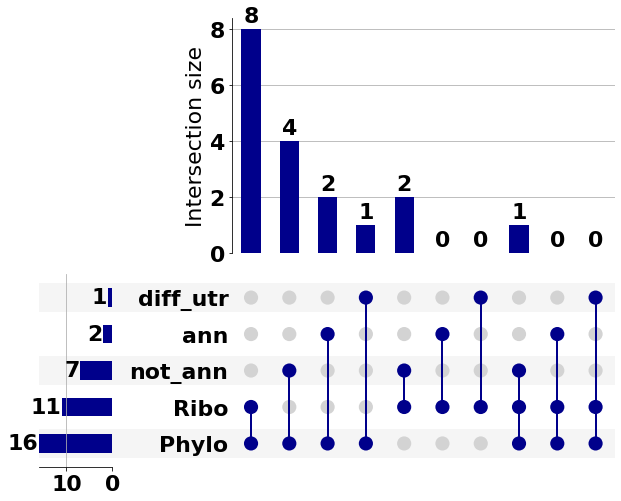

In [59]:
fig = plt.figure(figsize=(10, 8))

font = {'family' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

plot(example,show_counts='%d', 
     element_size=None, fig=fig,
    facecolor="darkblue")

plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)

plt.show()

In [35]:
len(set(phyloset_genes).intersection(ann_ext_24genes)), len(set(phyloset_genes).intersection(intact_ext_28genes)),len(set(phyloset_genes).intersection(diff_5leader_7genes))

(2, 4, 1)

In [36]:
len(set(riboset_genes).intersection(ann_ext_24genes)), len(set(riboset_genes).intersection(intact_ext_28genes)),len(set(riboset_genes).intersection(diff_5leader_7genes))

(0, 2, 0)

In [37]:
len(set(riboset_genes).intersection(ann_ext_24genes).intersection(phyloset_genes)), len(set(riboset_genes).intersection(intact_ext_28genes).intersection(phyloset_genes)), len(set(riboset_genes).intersection(diff_5leader_7genes).intersection(phyloset_genes))

(0, 1, 0)

In [38]:
# ann not_ann diff_utr Ribo Phylo

example = from_memberships([
['Phylo', 'Ribo'],
['Phylo', 'ann'],
['Phylo', 'not_ann'],
['Phylo', 'diff_utr'],
['Ribo', 'ann'],
['Ribo', 'not_ann'],
['Ribo', 'diff_utr'],
['Phylo', 'Ribo', 'ann'],
['Phylo', 'Ribo', 'not_ann'],
['Phylo', 'Ribo', 'diff_utr']],
data=[8, 2, 4, 1, 0, 2, 0, 0, 1, 0])

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7f22a8c0cd30>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7f22a8be4c88>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7f22a91fa470>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7f22a95a7358>}

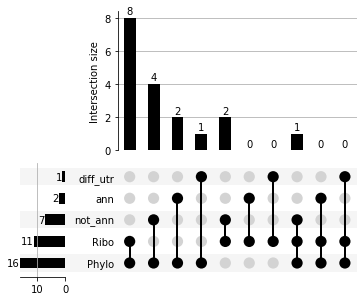

In [39]:
plot(example, show_counts='%d')

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7f22a57d2518>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7f22a57ee400>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7f22a52bf5c0>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7f22773bdd30>}

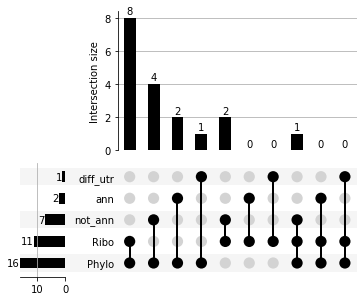

In [45]:
plot(example, show_counts='%d')

In [ ]:
Rse

In [65]:
# ann not_ann diff_utr Ribo Phylo

example = from_memberships([
    ['ann'],
    ['not_ann'],
    ['diff_utr'],
    ['Phylo'],
    ['Ribo'],
['Phylo', 'Ribo'],
['Phylo', 'ann'],
['Phylo', 'not_ann'],
['Phylo', 'diff_utr'],
['Ribo', 'ann'],
['Ribo', 'not_ann'],
['Ribo', 'diff_utr'],
['Phylo', 'Ribo', 'ann'],
['Phylo', 'Ribo', 'not_ann'],
['Phylo', 'Ribo', 'diff_utr']],
data=[24, 28, 7, 60, 392, 8, 2, 4, 1, 0, 2, 0, 0, 1, 0])

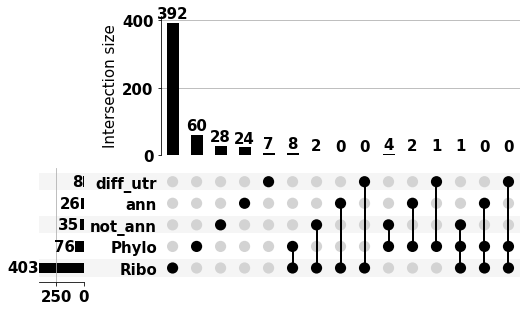

In [66]:
plt.rcParams.update({'font.size': 15})

plot(example, show_counts='%d')

plt.savefig('plots/upset_2011study', 
            format='svg', 
            width = 10,
            height = 10,
            dpi=1200, 
            bbox_inches="tight")


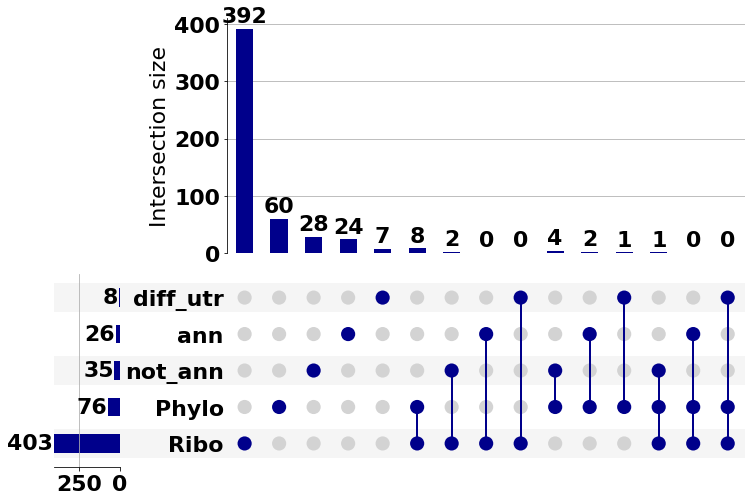

In [67]:
fig = plt.figure(figsize=(12, 8))

font = {'family' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

plot(example,show_counts='%d', 
     element_size=None, fig=fig,
    facecolor="darkblue")

plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)

plt.show()